## Embedding Edit Distance Learning

Embedding Edit Distance Learning (BEDL; [Paaßen et al., 2018](http://proceedings.mlr.press/v80/paassen18a.html)) is a technique to _learn_ the costs of edit operations instead of defining them manually. In particular, edit costs are optimized to support classification on the resulting edit distances.

In this script, we illustrate how BEDL works on the artificial data set from [Paaßen et al., (2018)](http://proceedings.mlr.press/v80/paassen18a.html). This data set has two classes of strings. In the first class, the strings follow the regular expression `[AB]{6}[CD]{AB}[5]` and in the second class, strings follow the regular expression `[AB]{5}[CD]{AB}[6]`. So the only difference is the location of the `c` or `d` character, while character frequencies are exactly the same.

In [1]:
# generate data
import numpy as np
m = 100
X = []
y = np.concatenate([np.zeros(50), np.ones(50)])
alphabet_1 = np.array(['a', 'b'])
alphabet_2 = np.array(['c', 'd'])
for i in range(m):
    x = alphabet_1[np.random.randint(2, size=12)]
    if(y[i] == 0):
        x[6] = alphabet_2[np.random.randint(2)]
    else:
        x[5] = alphabet_2[np.random.randint(2)]
    x = ''.join(x)
    X.append(x)

By studying the matrix of pairwise edit distances, we can see that the default edit distance is not suited to classify this data set; there is no structure visible. We can also verify that by training a classifier on this distance matrix and retrieving the training accuracy

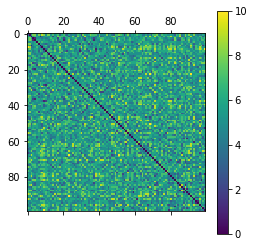

The classification accuracy on the standard edit distance is 61%


In [3]:
# compute the pairwise distance matrix
import edist.multiprocess as mp
import edist.sed as sed
D = mp.pairwise_distances_symmetric(X, sed.standard_sed)

# plot the matrix
import matplotlib.pyplot as plt
plt.matshow(D)
plt.colorbar()
plt.show()

# train a classifier on it
from proto_dist_ml.mglvq import MGLVQ
classifier = MGLVQ(1)
classifier.fit(D, y)
print('The classification accuracy on the standard edit distance is %g%%' % (classifier.score(D, y) * 100))

To improve the classification accuracy, we now do the following: We represent each of the symbols a, b, c, and d by a vector and adapt the positions of these vectors, such that the Euclidean distance between the vectors yields a good delta function for the sequence edit distance.

In [4]:
from edist.bedl import BEDL
distance_learner = BEDL(1)
distance_learner.fit(X, y);

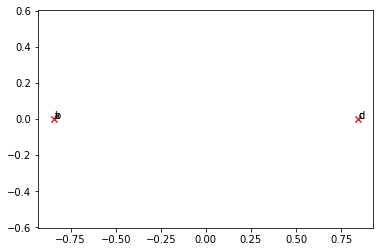

In [5]:
# plot the learned vectors for each symbol via PCA
from sklearn.decomposition import PCA
embed_pca = PCA(n_components=2).fit(distance_learner._embedding).transform(distance_learner._embedding)
symbols = ['a', 'b', 'c', 'd']
plt.plot(embed_pca[:, 0], embed_pca[:, 1], 'rx')
for s in range(len(symbols)):
    plt.text(embed_pca[s, 0], embed_pca[s, 1], symbols[s])
plt.axis('equal')
plt.show()

As we can see, a and b are embedded at the same location and c and d are embedded at the same location. This should yield a much nicer edit distance for our dataset.

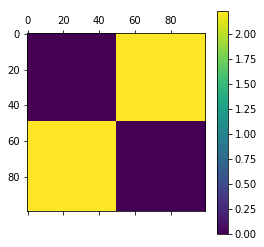

The classification accuracy on the learned edit distance is 100%


In [6]:
D_learned = mp.pairwise_distances_symmetric(X, sed.sed, delta=distance_learner._delta)
# plot the matrix
plt.matshow(D_learned)
plt.colorbar()
plt.show()

# train a classifier on it
classifier = MGLVQ(1)
classifier.fit(D_learned, y)
print('The classification accuracy on the learned edit distance is %g%%' % (classifier.score(D_learned, y) * 100))